# Dictionary Learning with K-SVD and GPU Acceleration

## Overview

This notebook implements dictionary learning using the K-SVD algorithm for sparse representation of signals, with support for GPU acceleration using PyTorch.

The implementation includes:
- Generalized Orthogonal Matching Pursuit (GenOMP)
- K-SVD dictionary update
- Batch Dictionary Learning (DL)
- Visualization and testing

The algorithm is particularly useful for image processing tasks such as denoising, compression, and inpainting.

## Setup and Dependencies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm
import torch
import scipy.io as sio
import time
import argparse

# Check if GPU is available
USE_GPU = torch.cuda.is_available()
if USE_GPU:
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected, using CPU")

# Configure matplotlib
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

No GPU detected, using CPU


## Core Functions

### Dictionary Normalization

Force every column of the dictionary to have unit ℓ2-norm.

In [2]:
def normalize_dictionary(D):
    """Force every column of D to have unit ℓ2-norm."""
    if isinstance(D, torch.Tensor):
        # GPU version
        D = D + torch.finfo(D.dtype).eps
        return D / torch.sqrt(torch.sum(D**2, dim=0, keepdim=True))
    else:
        # CPU version
        D = D + np.finfo(float).eps
        return D / np.sqrt(np.sum(D**2, axis=0, keepdims=True))

### Generalized Orthogonal Matching Pursuit (GenOMP)

The algorithm for sparse coding of signals, with both CPU and GPU implementations.

In [3]:
def gen_omp(D, y, T0=None, epsilon=0, N=1):
    """Generalized Orthogonal Matching Pursuit (batch size N)

    Parameters:
    -----------
    D : array, shape (n, K)
        Dictionary with unit-norm columns
    y : array, shape (n, 1)
        Signal (column vector)
    T0 : int, optional
        Maximum sparsity (positive integer)
    epsilon : float, optional
        Residual energy tolerance (0 to disable)
    N : int, optional
        Atoms added per iteration (default 1 -> standard OMP)

    Returns:
    --------
    x : array, shape (K, 1)
        Sparse coefficient vector
    """
    if USE_GPU:
        # GPU version
        return gen_omp_gpu(D, y, T0, epsilon, N)
    else:
        # CPU version
        if T0 is None:
            T0 = D.shape[1]

        # Pre-computations
        Dt = D.T                      # (K x n) - used often
        r = y.copy()                  # residual initialized to y
        supp = np.zeros(D.shape[1], dtype=bool)  # logical support mask

        # Main OMP / gOMP loop
        while True:
            # Stop if residual target met or support is full
            if (epsilon > 0 and np.sum(r**2) <= epsilon) or (np.sum(supp) >= T0):
                break  # finished

            # 1) Correlate residual with all atoms
            correlations = np.abs(Dt @ r)  # (K x 1)

            # 2) Pick the top-N atoms not yet selected
            correlations[supp] = -np.inf  # mask out existing support
            idx = np.argsort(correlations, axis=0)[::-1]  # descending sort
            new_atoms = idx[:min(N, T0 - np.sum(supp))]
            supp[new_atoms] = True

            # 3) Solve least-squares on the current support
            S = np.where(supp)[0]
            coefS = np.linalg.lstsq(D[:, S], y, rcond=None)[0]  # (|S| x 1) - via QR / lstsq

            # 4) Update residual
            r = y - D[:, S] @ coefS

        # Build full-length sparse vector
        x = np.zeros((D.shape[1], 1))
        if np.any(supp):
            x[supp] = coefS

        return x

In [4]:
def gen_omp_gpu(D, y, T0=None, epsilon=0, N=1):
    """GPU-accelerated Generalized Orthogonal Matching Pursuit"""
    # Convert numpy arrays to torch tensors if needed
    if not isinstance(D, torch.Tensor):
        D = torch.tensor(D, device='cuda', dtype=torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, device='cuda', dtype=torch.float32)

    if T0 is None:
        T0 = D.shape[1]

    # Pre-computations
    Dt = D.T                            # (K x n) - used often
    r = y.clone()                       # residual initialized to y
    supp = torch.zeros(D.shape[1], dtype=torch.bool, device='cuda')  # support mask

    # Main OMP / gOMP loop
    while True:
        # Stop if residual target met or support is full
        if (epsilon > 0 and torch.sum(r**2) <= epsilon) or (torch.sum(supp) >= T0):
            break  # finished

        # 1) Correlate residual with all atoms
        correlations = torch.abs(Dt @ r)  # (K x 1)

        # 2) Pick the top-N atoms not yet selected
        correlations[supp] = float('-inf')  # mask out existing support
        _, idx = torch.sort(correlations.squeeze(), descending=True)  # descending sort
        new_atoms = idx[:min(N, T0 - torch.sum(supp))]
        supp[new_atoms] = True

        # 3) Solve least-squares on the current support
        S = torch.nonzero(supp).squeeze()
        if S.dim() == 0 and S.numel() > 0:  # Handle case when S has only one element
            S = S.unsqueeze(0)

        # Use SVD-based least squares which is more stable on GPU
        DS = D[:, S]
        U, s, Vh = torch.linalg.svd(DS, full_matrices=False)
        s_inv = torch.where(s > 1e-10, 1.0/s, torch.zeros_like(s))
        coefS = Vh.T @ (s_inv.unsqueeze(1) * (U.T @ y))

        # 4) Update residual
        r = y - DS @ coefS

    # Build full-length sparse vector
    x = torch.zeros((D.shape[1], 1), device='cuda')
    if torch.any(supp):
        if S.dim() == 0 and S.numel() > 0:  # Handle case when S has only one element
            S = S.unsqueeze(0)
        x[S] = coefS

    # Keep as tensor if input was tensor
    if isinstance(D, torch.Tensor):
        return x
    else:
        return x.cpu().numpy()

### K-SVD Dictionary Update

The algorithm for updating dictionary atoms using rank-1 SVD approximation.

In [5]:
def ksvd(D, X, Y):
    """K-SVD dictionary update

    Updates every atom of D via rank-1 SVD. The sparse code matrix X must
    correspond to Y prior to calling. After the call both D and the selected
    rows of X are modified in-place.

    Parameters:
    -----------
    D : array or tensor, shape (n, K)
        Dictionary with unit-norm columns
    X : array or tensor, shape (K, Nsig)
        Sparse coefficients matrix
    Y : array or tensor, shape (n, Nsig)
        Training signals

    Returns:
    --------
    D : array or tensor, shape (n, K)
        Updated dictionary
    X : array or tensor, shape (K, Nsig)
        Updated sparse coefficients
    """
    if USE_GPU and isinstance(D, torch.Tensor):
        # GPU version
        return ksvd_gpu(D, X, Y)
    else:
        # CPU version
        _, K = D.shape

        for k in range(K):
            omega = np.where(X[k, :] != 0)[0]  # columns where atom participates
            if len(omega) == 0:
                # No signal currently uses atom - re-initialize with random sample
                rand_idx = np.random.randint(0, Y.shape[1])
                D[:, k] = Y[:, rand_idx]
                D[:, k] = D[:, k] / (np.linalg.norm(D[:, k]) + np.finfo(float).eps)
                continue

            # Build the error matrix without contribution of atom k
            E = Y - D @ X + np.outer(D[:, k], X[k, :])
            E_reduced = E[:, omega]

            # Rank-1 approximation via SVD
            U, S, Vh = np.linalg.svd(E_reduced, full_matrices=False)
            D[:, k] = U[:, 0]                 # new atom
            X[k, omega] = S[0] * Vh[0, :]     # corresponding coefficients

        D = normalize_dictionary(D)
        return D, X

In [6]:
def ksvd_gpu(D, X, Y):
    """GPU-accelerated K-SVD dictionary update"""
    _, K = D.shape

    for k in range(K):
        omega = torch.nonzero(X[k, :]).squeeze()  # columns where atom participates

        if omega.numel() == 0:
            # No signal currently uses atom - re-initialize with random sample
            rand_idx = torch.randint(0, Y.shape[1], (1,), device='cuda')
            D[:, k] = Y[:, rand_idx].squeeze()
            D[:, k] = D[:, k] / (torch.norm(D[:, k]) + torch.finfo(torch.float32).eps)
            continue

        # Handle case when omega has only one element
        if omega.dim() == 0:
            omega = omega.unsqueeze(0)

        # Build the error matrix without contribution of atom k
        Dk_term = D[:, k].unsqueeze(1) @ X[k, :].unsqueeze(0)  # outer product
        E = Y - D @ X + Dk_term
        E_reduced = E[:, omega]

        # Rank-1 approximation via SVD
        try:
            U, S, Vh = torch.linalg.svd(E_reduced, full_matrices=False)
            D[:, k] = U[:, 0]                    # new atom
            X[k, omega] = S[0] * Vh[0, :]        # corresponding coefficients
        except Exception as e:
            print(f"SVD failed for atom {k}, using fallback. Error: {e}")
            # Fallback - just normalize the first column
            if E_reduced.shape[1] > 0:
                v = E_reduced[:, 0]
                D[:, k] = v / (torch.norm(v) + torch.finfo(torch.float32).eps)

    D = normalize_dictionary(D)
    return D, X

### Dictionary Learning

The main dictionary learning algorithm, which alternates between sparse coding and dictionary update steps.

In [7]:
def dictionary_learning(D0, Y, T0, epsilon, no_epochs, N=1):
    """Dictionary Learning - batch scheme

    Parameters:
    -----------
    D0 : array, shape (n, K)
        Initial dictionary (random or supplied)
    Y : array, shape (n, Nsig)
        Training data
    T0 : int
        Target sparsity level passed to GenOMP
    epsilon : float
        Residual threshold passed to GenOMP
    no_epochs : int
        Total sweeps over all training signals
    N : int, optional
        Number of atoms per GenOMP iteration

    Returns:
    --------
    D : array, shape (n, K)
        Learned dictionary with unit-norm columns
    X : array, shape (K, Nsig)
        Final sparse code of training set
    mse_hist : array, shape (no_epochs,)
        Reconstruction MSE after each epoch
    """
    if USE_GPU:
        # Move data to GPU
        D0_gpu = torch.tensor(D0, device='cuda', dtype=torch.float32) if not isinstance(D0, torch.Tensor) else D0
        Y_gpu = torch.tensor(Y, device='cuda', dtype=torch.float32) if not isinstance(Y, torch.Tensor) else Y

        # Call GPU implementation
        D, X, mse_hist = dictionary_learning_gpu(D0_gpu, Y_gpu, T0, epsilon, no_epochs, N)

        # Convert results back to NumPy if input was NumPy
        if not isinstance(D0, torch.Tensor):
            D = D.cpu().numpy()
            X = X.cpu().numpy()
            mse_hist = mse_hist.cpu().numpy()
    else:
        # CPU implementation
        D = normalize_dictionary(D0)
        _, K = D.shape
        Nsig = Y.shape[1]
        X = np.zeros((K, Nsig))
        mse_hist = np.zeros(no_epochs)

        for epoch in range(no_epochs):
            t_start = time.time()

            # -------- Sparse coding step ------------------------
            for i in tqdm(range(Nsig), desc=f"Epoch {epoch+1}/{no_epochs} - Sparse coding", leave=False):
                X[:, i:i+1] = gen_omp(D, Y[:, i:i+1], T0, epsilon, N)

            # -------- Dictionary update step --------------------
            D, X = ksvd(D, X, Y)

            # -------- Progress metric ---------------------------
            mse_hist[epoch] = np.mean(np.sum((Y - D @ X)**2, axis=0))
            t_end = time.time()
            print(f'Epoch {epoch+1}/{no_epochs} - MSE: {mse_hist[epoch]:.4e} - Time: {t_end-t_start:.2f}s')

    return D, X, mse_hist

In [8]:
def dictionary_learning_gpu(D0, Y, T0, epsilon, no_epochs, N=1):
    """GPU-accelerated Dictionary Learning"""
    D = normalize_dictionary(D0)
    _, K = D.shape
    Nsig = Y.shape[1]
    X = torch.zeros((K, Nsig), device='cuda', dtype=torch.float32)
    mse_hist = torch.zeros(no_epochs, device='cuda', dtype=torch.float32)

    for epoch in range(no_epochs):
        t_start = time.time()

        # -------- Sparse coding step ------------------------
        # Process in batches to avoid GPU memory issues with large datasets
        batch_size = 100  # Adjust based on GPU memory
        for i in range(0, Nsig, batch_size):
            end_idx = min(i + batch_size, Nsig)
            for j in tqdm(range(i, end_idx), desc=f"Epoch {epoch+1}/{no_epochs} - Sparse coding", leave=False):
                X[:, j:j+1] = gen_omp_gpu(D, Y[:, j:j+1], T0, epsilon, N)

        # -------- Dictionary update step --------------------
        D, X = ksvd_gpu(D, X, Y)

        # -------- Progress metric ---------------------------
        error = Y - D @ X
        mse_hist[epoch] = torch.mean(torch.sum(error**2, dim=0))
        t_end = time.time()
        print(f'Epoch {epoch+1}/{no_epochs} - MSE: {mse_hist[epoch].item():.4e} - Time: {t_end-t_start:.2f}s')

    return D, X, mse_hist

## Visualization and Utility Functions

### Dictionary Visualization

In [9]:
def disp_d(D, blk=None):
    """Display dictionary atoms as images on a single figure

    Parameters:
    -----------
    D : array or tensor, shape (n, K)
        Dictionary with unit-norm columns, n = blk^2
    blk : int, optional
        Block (patch) edge length in pixels (default: sqrt(size(D,1)))
    """
    # Convert to numpy if tensor
    if isinstance(D, torch.Tensor):
        D = D.cpu().numpy()

    if blk is None:
        blk = int(np.round(np.sqrt(D.shape[0])))

    K = D.shape[1]
    cols = int(np.ceil(np.sqrt(K)))
    rows = int(np.ceil(K / cols))

    # Normalize each atom to [0, 1] for display
    Dimg = D - np.min(D, axis=0, keepdims=True)
    Dimg = Dimg / (np.max(Dimg, axis=0, keepdims=True) + np.finfo(float).eps)

    margin = 1  # pixels between atoms
    canvas = np.ones((rows*blk + (rows+1)*margin, cols*blk + (cols+1)*margin))

    k = 0
    for r in range(rows):
        for c in range(cols):
            if k >= K:
                break
            atom = Dimg[:, k].reshape(blk, blk)
            rr = (r)*(blk+margin) + margin + np.arange(blk)
            cc = (c)*(blk+margin) + margin + np.arange(blk)
            canvas[np.ix_(rr, cc)] = atom
            k += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(canvas, cmap='gray')
    plt.title(f'Dictionary atoms ({blk}×{blk})', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    
    return canvas  # Return for saving if needed

### Image Processing Utilities

In [10]:
def extract_blocks(I, block_size):
    """Extract non-overlapping blocks from image I"""
    h, w = I.shape
    blocks = []
    for i in range(0, h - block_size + 1, block_size):
        for j in range(0, w - block_size + 1, block_size):
            block = I[i:i+block_size, j:j+block_size].flatten()
            blocks.append(block)
    return np.array(blocks).T  # (block_size^2, num_blocks)

def assemble_image(B, im_size, block_size):
    """Assemble blocks B back into image of size im_size"""
    h, w = im_size
    img = np.zeros(im_size)
    idx = 0
    for i in range(0, h - block_size + 1, block_size):
        for j in range(0, w - block_size + 1, block_size):
            if idx < B.shape[1]:  # Check to avoid index errors
                img[i:i+block_size, j:j+block_size] = B[:, idx].reshape(block_size, block_size)
                idx += 1
    return img

## Main Functions for Dictionary Learning and Testing

This cell contains functions for the complete dictionary learning and image reconstruction pipeline.

In [11]:
def train_dictionary(train_dir, block_size=8, K=128, T0=5, epsilon=0, no_epochs=20, gomp_n=1):
    """Train a dictionary using images from train_dir"""
    # Set random seed for reproducibility
    np.random.seed(0)
    if USE_GPU:
        torch.manual_seed(0)
        
    # Get training images
    img_ext = ['*.png', '*.jpg', '*.bmp']
    tr_files = []
    for ext in img_ext:
        tr_files.extend(glob(os.path.join(train_dir, ext)))
        
    if not tr_files:
        print(f"No training images found in {train_dir}")
        return None, None, None
        
    print(f'Found {len(tr_files)} training images.')
    
    # Extract blocks from training images
    print(f'Extracting {block_size}x{block_size} blocks from training set...')
    Ytrain = []
    for img_path in tqdm(tr_files, desc="Processing training images"):
        I = np.array(Image.open(img_path).convert('L'), dtype=np.float32) / 255.0
        Ytrain.append(extract_blocks(I, block_size))

    Ytrain = np.hstack(Ytrain)  # Concatenate all blocks
    print(f"Total training blocks: {Ytrain.shape[1]}")
    
    # Initialize dictionary
    D0 = normalize_dictionary(np.random.randn(block_size**2, K))
    
    # Learn dictionary
    D, Xtrain, mse_hist = dictionary_learning(D0, Ytrain, T0, epsilon, no_epochs, gomp_n)
    
    return D, Xtrain, mse_hist, Ytrain

In [19]:
def test_dictionary(D, test_dir, block_size=8, T0=5, epsilon=0, gomp_n=1, max_viz=7):
    """Test a learned dictionary on images from test_dir"""
    # Get test images
    img_ext = ['*.png', '*.jpg', '*.bmp']
    te_files = []
    for ext in img_ext:
        te_files.extend(glob(os.path.join(test_dir, ext)))
        
    if not te_files:
        print(f"No test images found in {test_dir}")
        return None
        
    print(f'Found {len(te_files)} test images.')
    
    # Initialize arrays for results
    psnr_vals = np.zeros(len(te_files))
    mse_vals = np.zeros(len(te_files))
    mean_spars = np.zeros(len(te_files))
    xtest_cell = [None] * len(te_files)
    
    print('Reconstructing test images...')
    for i, img_path in enumerate(tqdm(te_files[:max_viz], desc="Processing test images")):
        # Load and convert to grayscale
        I = np.array(Image.open(img_path).convert('L'), dtype=np.float32) / 255.0
        h, w = I.shape

        # Sparse code every block
        Blks = extract_blocks(I, block_size)
        K = D.shape[1]
        Xtmp = np.zeros((K, Blks.shape[1]))

        # Move to GPU for processing if available
        if USE_GPU:
            D_gpu = D if isinstance(D, torch.Tensor) else torch.tensor(D, device='cuda', dtype=torch.float32)
            Blks_gpu = torch.tensor(Blks, device='cuda', dtype=torch.float32)
            Xtmp_gpu = torch.zeros((K, Blks.shape[1]), device='cuda', dtype=torch.float32)

            for b in range(Blks.shape[1]):
                Xtmp_gpu[:, b:b+1] = gen_omp_gpu(D_gpu, Blks_gpu[:, b:b+1], T0, epsilon, gomp_n)

            Rblks_gpu = D_gpu @ Xtmp_gpu
            Xtmp = Xtmp_gpu.cpu().numpy()
            Rblks = Rblks_gpu.cpu().numpy()
        else:
            for b in range(Blks.shape[1]):
                Xtmp[:, b:b+1] = gen_omp(D, Blks[:, b:b+1], T0, epsilon, gomp_n)

            Rblks = D @ Xtmp

        Irec = assemble_image(Rblks, (h, w), block_size)
        Irec = np.clip(Irec, 0, 1)

        # Calculate metrics
        mse_vals[i] = np.mean((Irec - I)**2)
        psnr_vals[i] = 10 * np.log10(1 / mse_vals[i])
        mean_spars[i] = np.mean(np.sum(Xtmp != 0, axis=0))
        xtest_cell[i] = Xtmp

        # Display results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(I, cmap='gray')
        plt.title(f'Original - {os.path.basename(img_path)}', fontsize=10)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(Irec, cmap='gray')
        plt.title(f'Reconstruction - PSNR {psnr_vals[i]:.2f} dB', fontsize=10)
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f'\nTest-set summary over {len(te_files[:max_viz])} images:')
    print(f'  Average PSNR : {np.mean(psnr_vals[:max_viz]):.2f} dB (std {np.std(psnr_vals[:max_viz]):.2f})')
    print(f'  Average MSE  : {np.mean(mse_vals[:max_viz]):.4e}')
    print(f'  Mean sparsity: {np.mean(mean_spars[:max_viz]):.2f} coefficients per block')
    
    return xtest_cell, psnr_vals, mse_vals, mean_spars

## Running the Dictionary Learning Pipeline

Now we'll run the complete dictionary learning and image reconstruction pipeline. You can adjust the parameters below to experiment with different settings.

In [21]:
# Define parameters
block_size = 8    # Patch dimension (pixels)
K = 128           # Dictionary atoms
T0 = 5            # Sparsity per block
epsilon = 0       # Residual threshold (0 -> off)
no_epochs = 10    # Dictionary learning epochs (reduced from original for faster execution)
gomp_n = 1        # GenOMP batch size (1 -> standard OMP)
max_viz = 7       # Maximum number of test images to visualize
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Check if there are images in the directories
img_ext = ['*.png', '*.jpg', '*.bmp']
tr_files = []
te_files = []
for ext in img_ext:
    tr_files.extend(glob(os.path.join(train_dir, ext)))
    te_files.extend(glob(os.path.join(test_dir, ext)))

if not tr_files or not te_files:
    print("Warning: No images found in one or both directories.")
    print("Please add some image files (PNG, JPG, BMP) to both the train and test directories before running the next cell.")

Found 15 training images.
Extracting 8x8 blocks from training set...


Processing training images: 100%|██████████| 15/15 [00:00<00:00, 27.06it/s]


Total training blocks: 486000


Epoch 1/10 - MSE: 2.7998e-01 - Time: 109.77s


Epoch 2/10 - MSE: 1.2924e-01 - Time: 104.45s


Epoch 3/10 - MSE: 8.4426e-02 - Time: 776.93s


Epoch 4/10 - MSE: 6.9474e-02 - Time: 106.56s


Epoch 5/10 - MSE: 6.5495e-02 - Time: 120.94s


Epoch 6/10 - MSE: 6.0410e-02 - Time: 113.87s


Epoch 7/10 - MSE: 5.9214e-02 - Time: 112.19s


Epoch 8/10 - MSE: 5.8311e-02 - Time: 115.83s


Epoch 9/10 - MSE: 5.3053e-02 - Time: 109.88s


Epoch 10/10 - MSE: 5.1536e-02 - Time: 109.07s


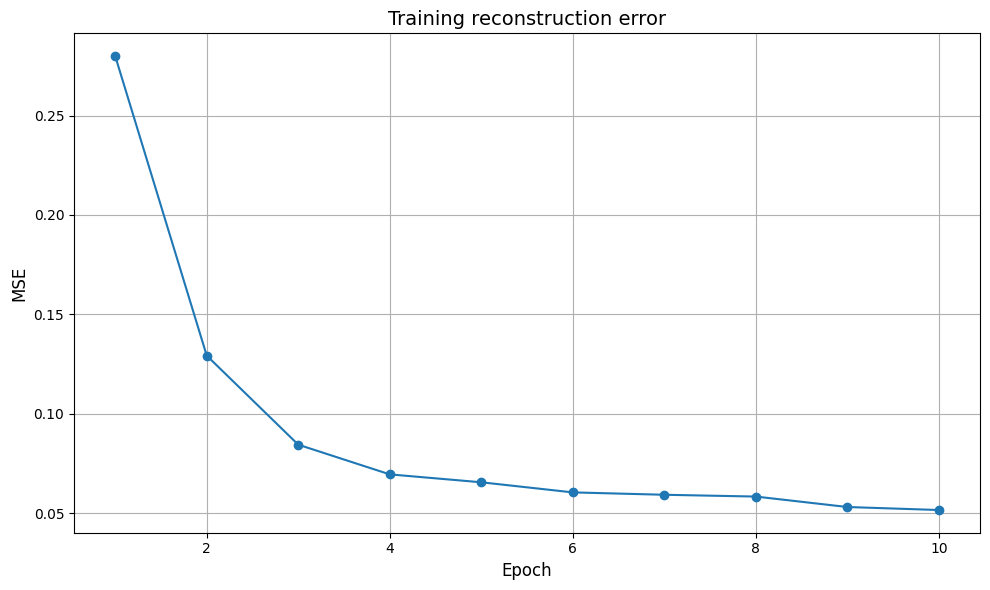

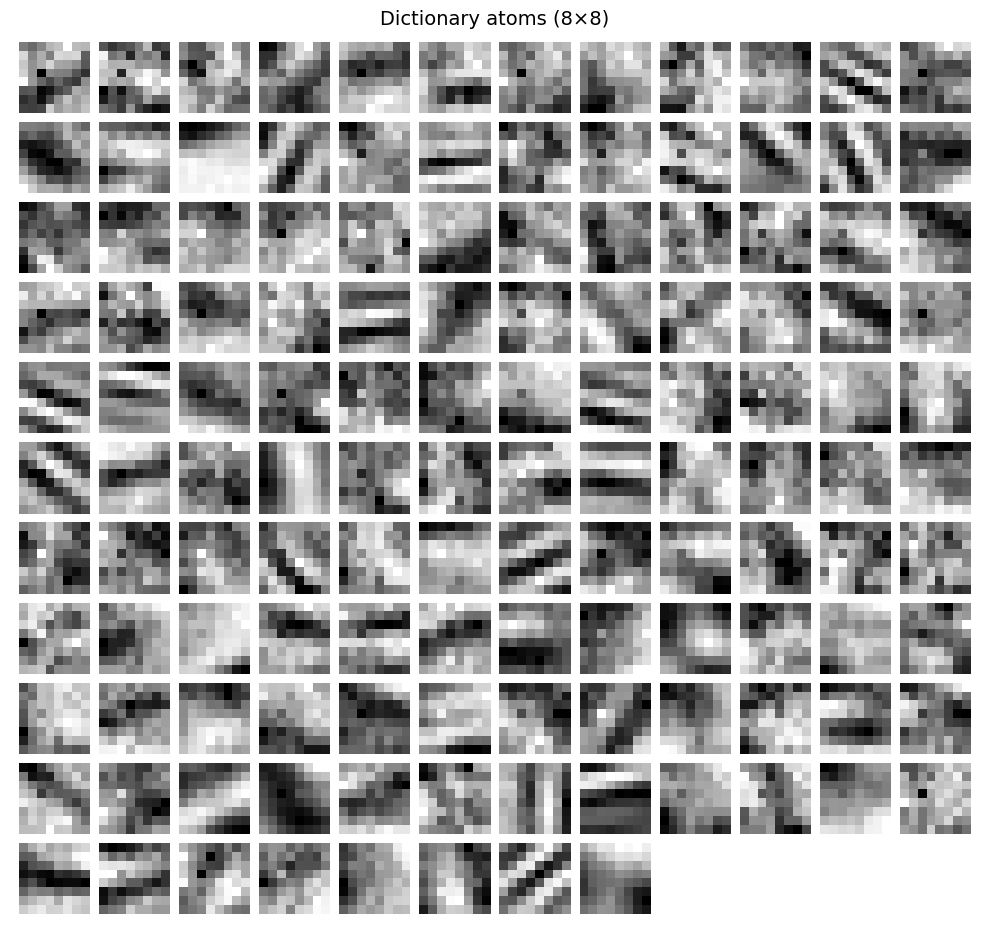

In [14]:
# Train the dictionary
D, Xtrain, mse_hist, Ytrain = train_dictionary(
    train_dir, block_size, K, T0, epsilon, no_epochs, gomp_n
)

if D is not None:
    # Plot the training MSE history
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, no_epochs+1), mse_hist, '-o', linewidth=1.5)
    plt.grid(True)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.title('Training reconstruction error', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Visualize the dictionary
    disp_d(D, block_size)

Found 7 test images.
Reconstructing test images...


Processing test images:   0%|          | 0/7 [00:00<?, ?it/s]

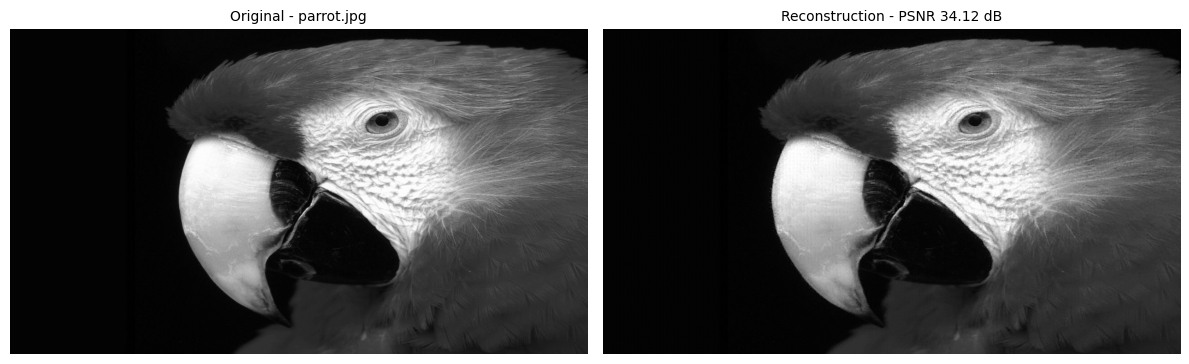

Processing test images:  14%|█▍        | 1/7 [00:02<00:13,  2.19s/it]

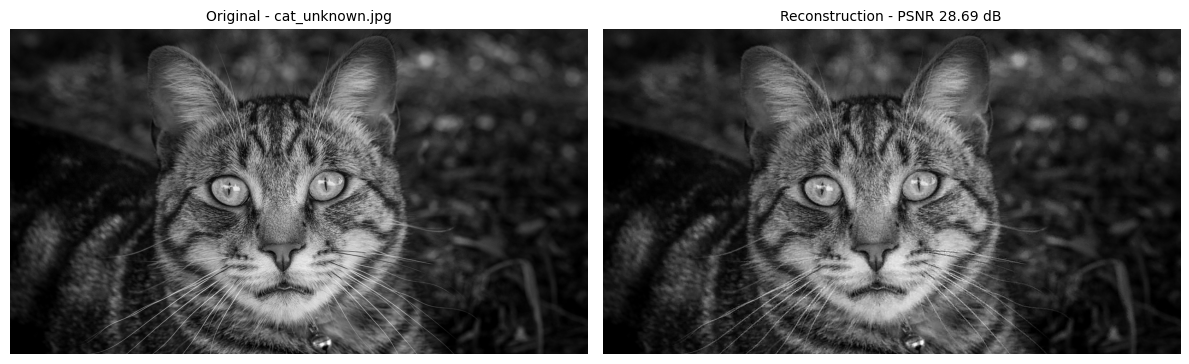

Processing test images:  29%|██▊       | 2/7 [00:04<00:11,  2.20s/it]

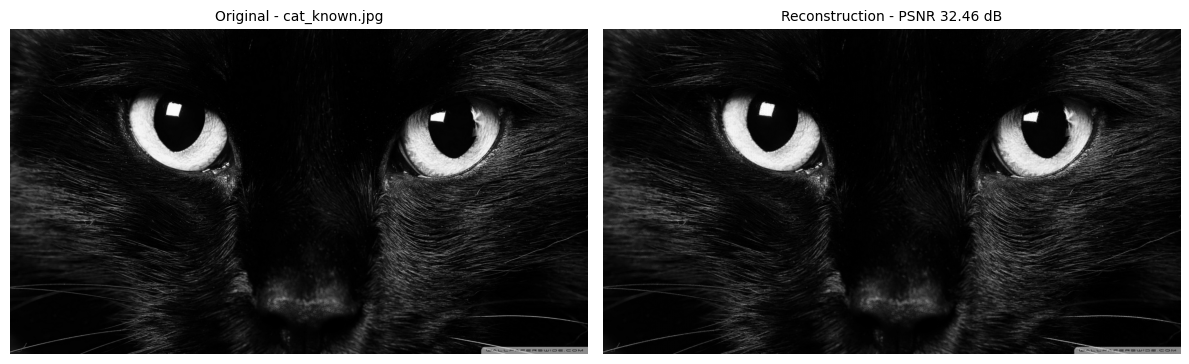

Processing test images:  43%|████▎     | 3/7 [00:09<00:13,  3.39s/it]

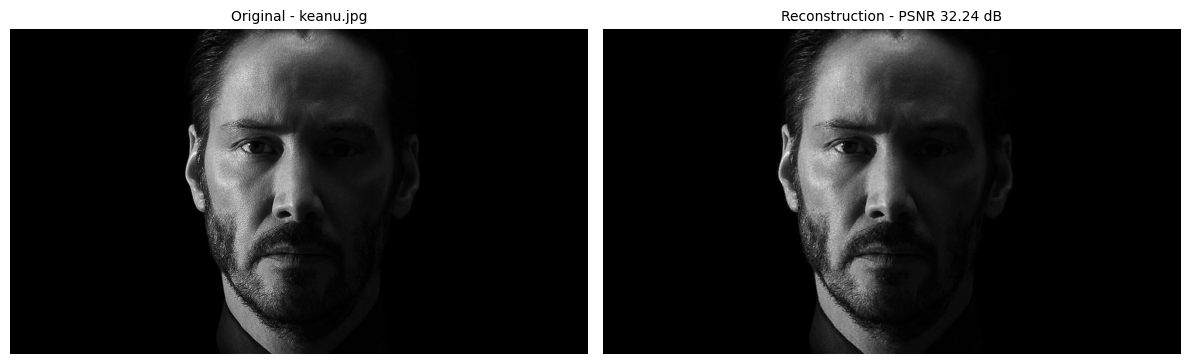

Processing test images:  57%|█████▋    | 4/7 [00:11<00:08,  2.85s/it]

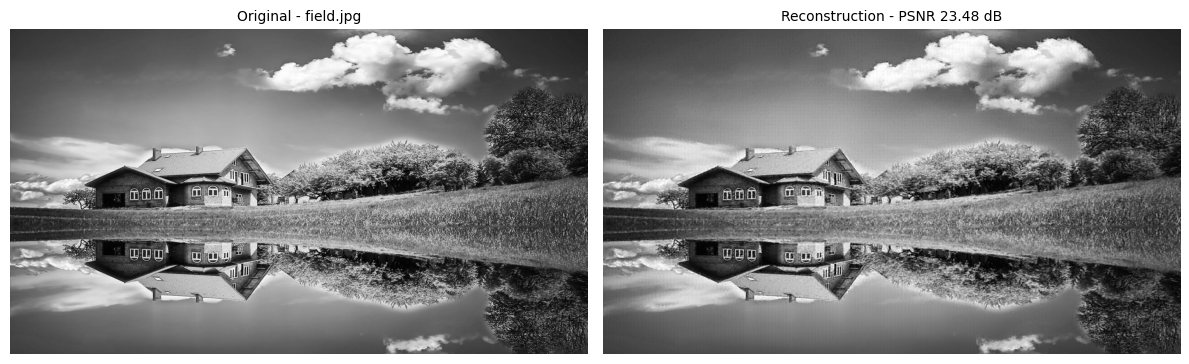

Processing test images:  71%|███████▏  | 5/7 [00:13<00:05,  2.60s/it]

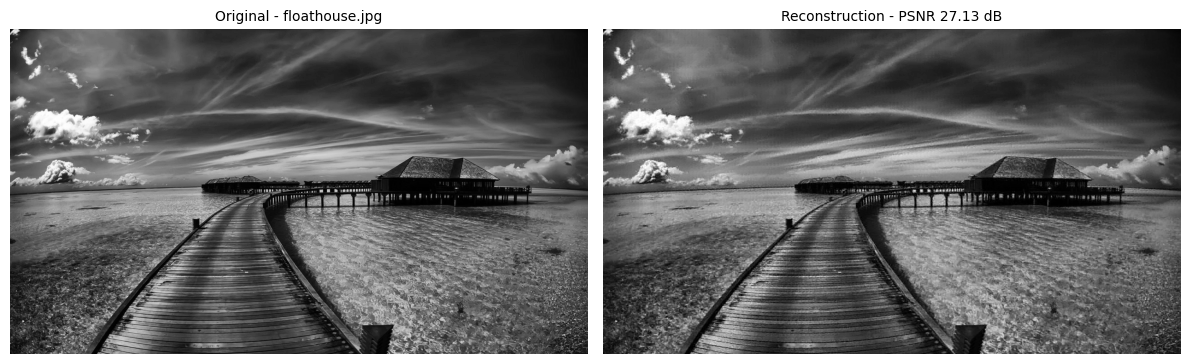

Processing test images:  86%|████████▌ | 6/7 [00:15<00:02,  2.46s/it]

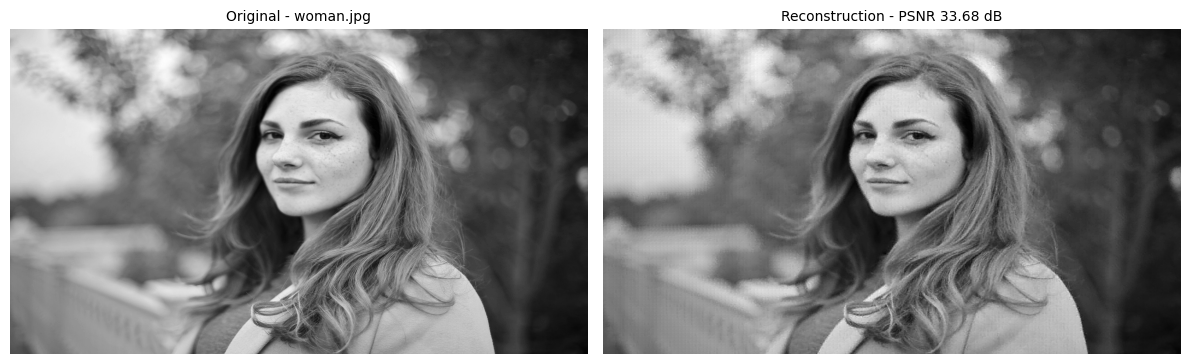

Processing test images: 100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Test-set summary over 7 images:
  Average PSNR : 30.26 dB (std 3.66)
  Average MSE  : 1.3944e-03
  Mean sparsity: 4.54 coefficients per block


In [22]:
# Test the dictionary
if D is not None:
    xtest_cell, psnr_vals, mse_vals, mean_spars = test_dictionary(
        D, test_dir, block_size, T0, epsilon, gomp_n, max_viz
    )

In [23]:
# Print the MSE for each test image
if mse_vals is not None:
    for i, mse in enumerate(mse_vals):
        print(f"Image {i + 1}: MSE = {mse:.4e}")

Image 1: MSE = 3.8708e-04
Image 2: MSE = 1.3522e-03
Image 3: MSE = 5.6813e-04
Image 4: MSE = 5.9707e-04
Image 5: MSE = 4.4908e-03
Image 6: MSE = 1.9373e-03
Image 7: MSE = 4.2822e-04


## Save Results

Save the learned dictionary and other results for later use.

In [16]:
def save_results(D, Xtrain, Ytrain, xtest_cell, psnr_vals, mse_vals, mean_spars):
    """Save the results to files"""
    # Convert to numpy if tensors
    D_np = D.cpu().numpy() if isinstance(D, torch.Tensor) else D
    Xtrain_np = Xtrain.cpu().numpy() if isinstance(Xtrain, torch.Tensor) else Xtrain
    
    # Save in NumPy format
    np.savez('D.npz', D=D_np)
    np.savez('Xtrain.npz', Xtrain=Xtrain_np)
    np.savez('Ytrain.npz', Ytrain=Ytrain)
    np.savez('Ytest_stats.npz', psnr_vals=psnr_vals, mse_vals=mse_vals, mean_spars=mean_spars)
    
    # For Xtest, save each test image's sparse code separately
    for i, x in enumerate(xtest_cell):
        if x is not None:  # Some might be None if we didn't process all test images
            np.savez(f'Xtest_{i}.npz', x=x)
    
    # Also save in MATLAB format for compatibility
    import scipy.io as sio
    sio.savemat('D.mat', {'D': D_np})
    sio.savemat('Xtrain.mat', {'Xtrain': Xtrain_np})
    sio.savemat('Ytrain.mat', {'Ytrain': Ytrain})
    
    # For MATLAB compatibility with cell arrays, we need special handling
    xtest_dict = {}
    for i, x in enumerate(xtest_cell):
        if x is not None:
            xtest_dict[f'XtestCell_{i}'] = x
    
    sio.savemat('Xtest.mat', xtest_dict)
    sio.savemat('Ytest_stats.mat', {'psnrVals': psnr_vals, 'mseVals': mse_vals, 'meanSpars': mean_spars})
    print('Saved D.mat, Xtrain.mat, Xtest.mat, Ytrain.mat, and stats.')

In [17]:
# Save the results if dictionary training was successful
if D is not None and Xtrain is not None and Ytrain is not None and xtest_cell is not None:
    save_results(D, Xtrain, Ytrain, xtest_cell, psnr_vals, mse_vals, mean_spars)

Saved D.mat, Xtrain.mat, Xtest.mat, Ytrain.mat, and stats.
